In [59]:
import cv2
import numpy as np
import os, time, glob
from collections import defaultdict, deque
from dataclasses import dataclass
import matplotlib.pyplot as plt
import pandas as pd

In [44]:
current_dir = os.getcwd()
dataset_dir = os.path.join(current_dir, "data")

In [103]:
MATCH_RATIO = 0.75         # Lowe ratio
RANSAC_REPROJ_THR = 3.0    # for geometric check
MIN_TRACK_LEN = 5          # landmark

In [46]:
MAX_FRAMES = None          # None = all frames; or set an int

def load_frames(folder):
    files = []
    files.extend(glob.glob(os.path.join(folder, "*.png")))
    files = sorted(files)
    if MAX_FRAMES: 
        files = files[:MAX_FRAMES]
    imgs = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in files]
    return imgs

imgs = load_frames(dataset_dir)
print(f"Loaded {len(imgs)} frames from {dataset_dir}")

Loaded 200 frames from C:\Users\user\Desktop\classic-vision\data


In [47]:
@dataclass
class DetectionResult:
    key_points: list   # list[cv2.KeyPoint]
    desc: np.ndarray   # descriptor array
    time_ms: float     # keeping that to keep the avg

def detect_sift(img):
    t0 = time.time()
    sift = cv2.SIFT_create()
    key_points, desc = sift.detectAndCompute(img, None)
    dt = (time.time() - t0)*1000
    return DetectionResult(key_points, desc, dt)

def detect_orb(img, nfeatures=2000):
    t0 = time.time()
    orb = cv2.ORB_create(nfeatures=nfeatures)
    key_points, desc = orb.detectAndCompute(img, None)
    dt = (time.time() - t0)*1000
    return DetectionResult(key_points, desc, dt)


def detect_harris_with_orb_descriptors(img, blockSize=2, ksize=3, k=0.04, thresh_rel=0.01, nfeatures_desc=2000):
    t0 = time.time()

    # Harris corner response (score at every pixel)
    h = cv2.cornerHarris(np.float32(img), blockSize, ksize, k) # the corner Strength at every pixel location in the whole image.
                                                               # is a a map of scores.
    # With dilation: A whole small patch around the corner is above the threshold.
    h = cv2.dilate(h, None)

    # Pick pixels with score > (thresh_rel * max score)
    thresh = thresh_rel * h.max()
    ys, xs = np.where(h > thresh)
    if len(xs) == 0:
        return DetectionResult([], None, (time.time() - t0)*1000)

    # Sort by score and keep TOP-N, by nfeatures_desc
    scores = h[ys, xs]
    top_idx = np.argsort(-scores)[:nfeatures_desc]
    xs, ys = xs[top_idx], ys[top_idx]

    # Make keypoints for those positions
    key_points = [cv2.KeyPoint(float(x), float(y), 3) for x, y in zip(xs, ys)]

    # ORB: compute descriptors only (does not detect here)
    orb = cv2.ORB_create()
    key_points, desc = orb.compute(img, key_points)

    dt = (time.time() - t0)*1000
    return DetectionResult(key_points or [], desc, dt)



In [51]:
def bf_match(desc1, desc2, method):
    if desc1 is None or desc2 is None: return []
    if method == "SIFT": norm = cv2.NORM_L2
    else:                norm = cv2.NORM_HAMMING
    bf = cv2.BFMatcher(norm, crossCheck=False)
    try:
        knn = bf.knnMatch(desc1, desc2, k=2)
    except cv2.error:
        return []
    good = []
    for m,n in knn:
        if m.distance < MATCH_RATIO * n.distance:
            good.append(m)
    return good

def geometric_filter(key_points1, key_points2, matches, ransac_thr=RANSAC_REPROJ_THR):
    if len(matches) < 8: return []
    pts1 = np.float32([key_points1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([key_points2[m.trainIdx].pt for m in matches])
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransac_thr)
    mask = mask.ravel().astype(bool) if mask is not None else np.zeros(len(matches), bool)
    return [m for m,ok in zip(matches, mask) if ok]


In [97]:
# This class stores information about a tracked feature across multiple frames
@dataclass
class FeatureTrack:
    track_id: int                  # Unique identifier for this track
    last_frame_index: int          # Last frame index where this track was seen
    consecutive_length: int        # How many consecutive frames it's been matched in
    recent_positions: deque        # Recent (x, y) positions for visualization

In [91]:
def find_features_for_all_pics(detection_method, image_list):
    detection_results = []
    keypoints_per_frame_count = []
    
    for image in image_list:
        result = detection_method(image)
        detection_results.append(result)
        keypoints_per_frame_count.append(len(result.key_points))

    return detection_results, keypoints_per_frame_count

In [303]:
def find_matches_between_consecutive_frames(detection_results, n_pairs, method):
    """Return list[matches] for frame i -> i+1, i in [0, n_pairs-1]."""
    matches_pics = []
    for i in range(n_pairs):
        raw = bf_match(
            detection_results[i].desc,
            detection_results[i + 1].desc,
            method
        )
        geo = geometric_filter(
            detection_results[i].key_points,
            detection_results[i + 1].key_points,
            raw,
            ransac_thr=RANSAC_REPROJ_THR
        )
        matches_pics.append(geo)
    return matches_pics


In [287]:
def initialize_tracks_from_first_frame(detection_results, frame_keypoint_to_track, next_track_id):
    """Create a new track for every keypoint in the first frame."""
    all_tracks = {}
    for kp_index, _ in enumerate(detection_results[0].key_points):
        frame_keypoint_to_track[0][kp_index] = next_track_id
        all_tracks[next_track_id] = FeatureTrack(
            track_id=next_track_id,
            last_frame_index=0,
            consecutive_length=1,
            recent_positions=deque(maxlen=MIN_TRACK_LEN)
        )
        position_xy = detection_results[0].key_points[kp_index].pt
        all_tracks[next_track_id].recent_positions.append(position_xy)
        next_track_id += 1
    return all_tracks, next_track_id


In [289]:
def propagate_tracks_forward(
    detection_results,
    matches_between_frames,
    frame_keypoint_to_track,
    all_tracks,
    next_track_id
):
    """Propagate existing tracks forward and start new tracks for unmatched keypoints."""
    for frame_index in range(len(detection_results) - 1):
        current_map = frame_keypoint_to_track[frame_index]
        next_map = frame_keypoint_to_track[frame_index + 1]

        # Update existing tracks
        for match in matches_between_frames[frame_index]:
            prev_kp_index = match.queryIdx
            next_kp_index = match.trainIdx

            if prev_kp_index in current_map:
                track_id = current_map[prev_kp_index]
                next_map[next_kp_index] = track_id
                track_data = all_tracks[track_id]

                if track_data.last_frame_index == frame_index:
                    track_data.consecutive_length += 1
                    track_data.last_frame_index = frame_index + 1
                    track_data.recent_positions.append(
                        detection_results[frame_index + 1].key_points[next_kp_index].pt
                    )

        # Start new tracks for unmatched keypoints
        matched_next_indices = set(next_map.keys())
        for next_kp_index in range(len(detection_results[frame_index + 1].key_points)):
            if next_kp_index not in matched_next_indices:
                frame_keypoint_to_track[frame_index + 1][next_kp_index] = next_track_id
                all_tracks[next_track_id] = FeatureTrack(
                    track_id=next_track_id,
                    last_frame_index=frame_index + 1,
                    consecutive_length=1,
                    recent_positions=deque(maxlen=MIN_TRACK_LEN)
                )
                position_xy = detection_results[frame_index + 1].key_points[next_kp_index].pt
                all_tracks[next_track_id].recent_positions.append(position_xy)
                next_track_id += 1

    return all_tracks, next_track_id


In [291]:
def count_stable_landmarks(all_tracks, min_track_length):
    """Count tracks that meet the stability threshold."""
    return sum(1 for track in all_tracks.values() if track.consecutive_length >= min_track_length)

In [293]:
def draw_matches_from_outputs(
    image_list,
    detection_results,
    matches_between_frames,
    frame_index,
    max_draw=60
):
    """
    Draw side-by-side matches for frames frame_index -> frame_index+1
    using only the pipeline outputs.
    """
    img_a = image_list[frame_index]
    img_b = image_list[frame_index + 1]
    kps_a = detection_results[frame_index].key_points
    kps_b = detection_results[frame_index + 1].key_points
    matches = matches_between_frames[frame_index][:max_draw]

    vis = cv2.drawMatches(
        img_a, kps_a,
        img_b, kps_b,
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    return vis


In [295]:
def run_pipeline(image_list, method="SIFT"):
    # 0) pick detector
    if method == "SIFT":
        detect_features = detect_sift
    elif method == "ORB":
        detect_features = detect_orb
    elif method == "HARRIS":
        detect_features = detect_harris_with_orb_descriptors
    else:
        raise ValueError("method must be SIFT | ORB | HARRIS")

    start_det = time.time()
    detection_results, keypoints_per_frame_count = find_features_for_all_pics(
        detect_features, image_list
    )
    runtime_ms_total_detection = (time.time() - start_det) * 1000.0

    start_match = time.time()
    matches_between_frames = find_matches_between_consecutive_frames(
        detection_results, len(image_list) - 1, method
    )
    runtime_ms_total_matching = (time.time() - start_match) * 1000.0

    frame_keypoint_to_track = [dict() for _ in range(len(image_list))]
    all_tracks, next_track_id = initialize_tracks_from_first_frame(
        detection_results, frame_keypoint_to_track, 0
    )
    all_tracks, next_track_id = propagate_tracks_forward(
        detection_results,
        matches_between_frames,
        frame_keypoint_to_track,
        all_tracks,
        next_track_id
    )

    landmark_count = count_stable_landmarks(all_tracks, MIN_TRACK_LEN)

    metrics = {
        "method": method,
        # runtimes
        "runtime_ms_total_detection": runtime_ms_total_detection,
        "runtime_ms_total_matching": runtime_ms_total_matching,
        "runtime_ms_total_pipeline": runtime_ms_total_detection + runtime_ms_total_matching,
        "runtime_ms_per_frame_avg": float(np.mean([d.time_ms for d in detection_results])),
        # feature stats
        "avg_candidates_per_frame": float(np.mean(keypoints_per_frame_count)),
        f"num_landmarks_ge_{MIN_TRACK_LEN}": landmark_count,
        # run params (useful for your summary table)
        "min_track_len": MIN_TRACK_LEN,
        "ransac_threshold": RANSAC_REPROJ_THR,
        "match_ratio": MATCH_RATIO,
        "matcher": "BF",
        "geometric_model": "homography(RANSAC)",
    }

    return metrics, detection_results, matches_between_frames, all_tracks
    

In [297]:
def count_landmarks_from_tracks(all_tracks, min_track_length):
    return sum(1 for t in all_tracks.values() if t.consecutive_length >= min_track_length)

def plot_landmark_points_on_last_frame(image_list, all_tracks, min_track_length, radius=3):
    landmarks = {tid: t for tid, t in all_tracks.items() if t.consecutive_length >= min_track_length}
    if not landmarks:
        return None
    base = image_list[-1]
    if base.ndim == 2:
        base = cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)
    out = base.copy()
    for t in landmarks.values():
        if t.recent_positions:
            x, y = map(int, t.recent_positions[-1])
            cv2.circle(out, (x, y), radius, (0, 255, 0), -1)
    return out

def plot_landmark_paths(image_list, all_tracks, min_track_length, thickness=1):
    landmarks = {tid: t for tid, t in all_tracks.items() if t.consecutive_length >= min_track_length}
    if not landmarks:
        return None
    base = image_list[-1]
    if base.ndim == 2:
        base = cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)
    out = base.copy()
    for t in landmarks.values():
        pts = list(t.recent_positions)
        for a, b in zip(pts, pts[1:]):
            cv2.line(out, tuple(map(int, a)), tuple(map(int, b)), (0, 255, 0), thickness)
        if pts:
            cv2.circle(out, tuple(map(int, pts[-1])), 2, (0, 255, 0), -1)
    return out


In [227]:
methods = ["SIFT", "ORB", "HARRIS"]
all_results = {}
tracks_by_method = {}

for method in methods:
    print(f"\n=== {method} ===")
    metrics, detection_results, matches_between_frames, all_tracks = run_pipeline(imgs, method=method)
    all_results[method] = {  # store all the important stuff
        "metrics": metrics,
        "detection_results": detection_results,
        "matches_between_frames": matches_between_frames,
        "all_tracks": all_tracks
    }
    tracks_by_method[method] = all_tracks
    print(metrics)



=== SIFT ===
{'method': 'SIFT', 'runtime_ms_total_detection': 13853.752613067627, 'runtime_ms_total_matching': 5006.376504898071, 'runtime_ms_total_pipeline': 18860.1291179657, 'runtime_ms_per_frame_avg': 69.25381422042847, 'avg_candidates_per_frame': 2540.5, 'num_landmarks_ge_5': 10410, 'min_track_len': 5, 'ransac_threshold': 3.0, 'match_ratio': 0.75, 'matcher': 'BF', 'geometric_model': 'homography(RANSAC)'}

=== ORB ===
{'method': 'ORB', 'runtime_ms_total_detection': 1819.807767868042, 'runtime_ms_total_matching': 2788.572072982788, 'runtime_ms_total_pipeline': 4608.37984085083, 'runtime_ms_per_frame_avg': 9.074068069458008, 'avg_candidates_per_frame': 2000.0, 'num_landmarks_ge_5': 10362, 'min_track_len': 5, 'ransac_threshold': 3.0, 'match_ratio': 0.75, 'matcher': 'BF', 'geometric_model': 'homography(RANSAC)'}

=== HARRIS ===
{'method': 'HARRIS', 'runtime_ms_total_detection': 2268.8965797424316, 'runtime_ms_total_matching': 2292.3169136047363, 'runtime_ms_total_pipeline': 4561.21349

Landmarks ≥5 frames: 10410


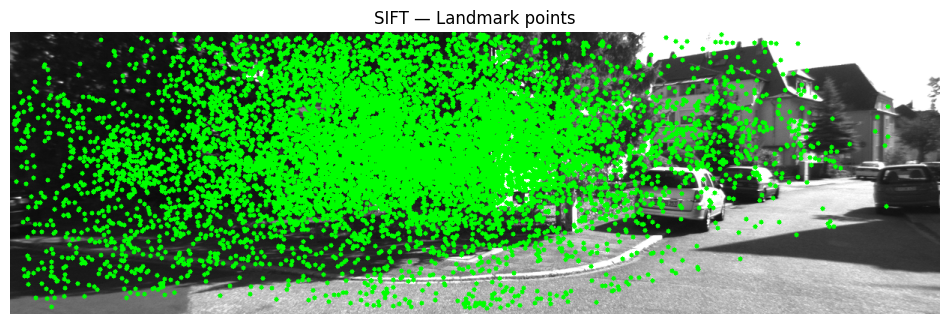

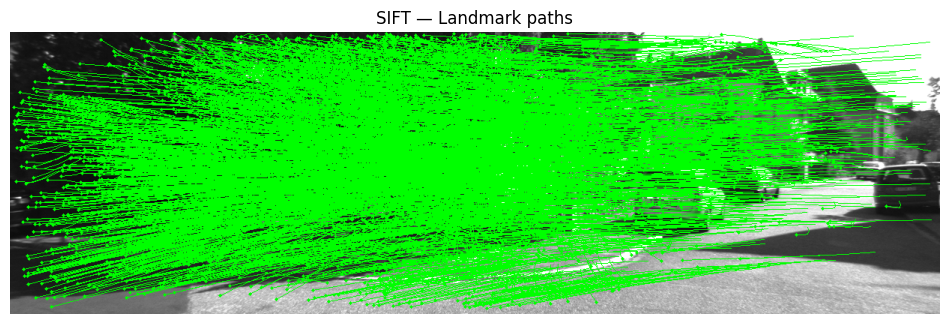

Landmarks ≥5 frames: 10362


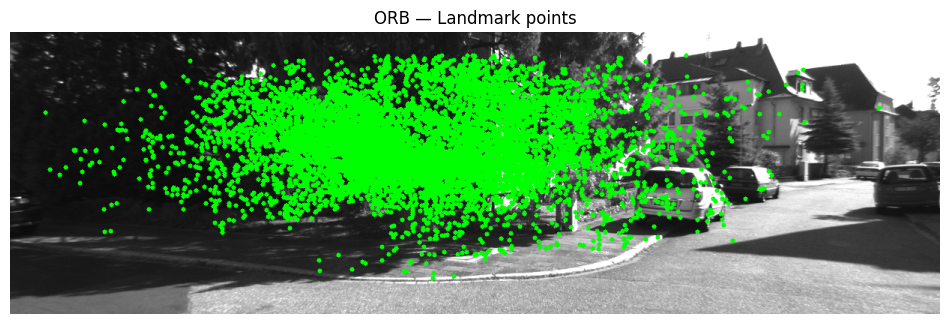

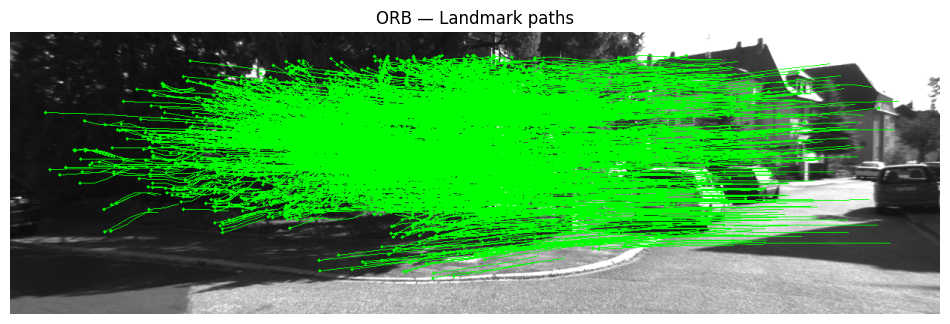

Landmarks ≥5 frames: 5618


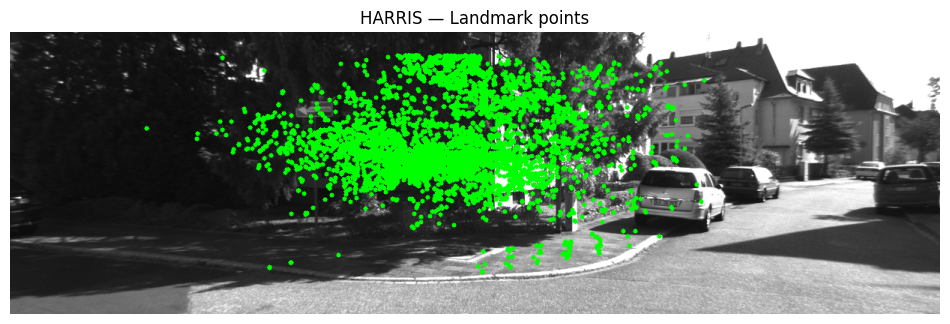

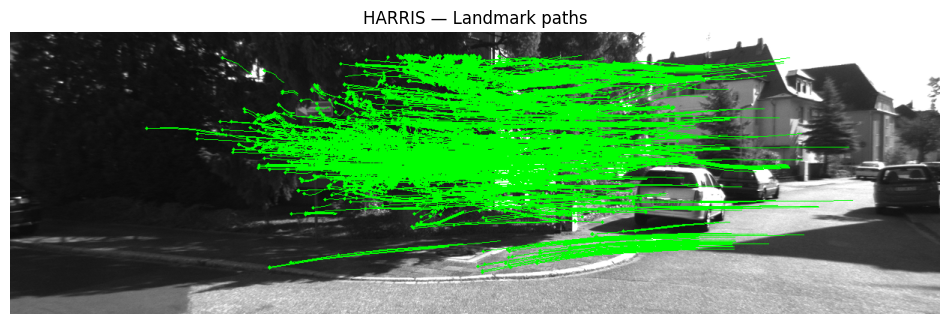

In [209]:
for method in ["SIFT", "ORB", "HARRIS"]:
    all_tracks = tracks_by_method[method]
    
    num_landmarks = count_landmarks_from_tracks(all_tracks, MIN_TRACK_LEN)
    print(f"Landmarks ≥{MIN_TRACK_LEN} frames: {num_landmarks}")

    landmark_img = plot_landmark_points_on_last_frame(imgs, all_tracks, MIN_TRACK_LEN)
    if landmark_img is not None:
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(landmark_img, cv2.COLOR_BGR2RGB))
        plt.title(f"{method} — Landmark points")
        plt.axis('off')
        plt.show()

    landmark_paths_img = plot_landmark_paths(imgs, all_tracks, MIN_TRACK_LEN)
    if landmark_paths_img is not None:
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(landmark_paths_img, cv2.COLOR_BGR2RGB))
        plt.title(f"{method} — Landmark paths")
        plt.axis('off')
        plt.show()

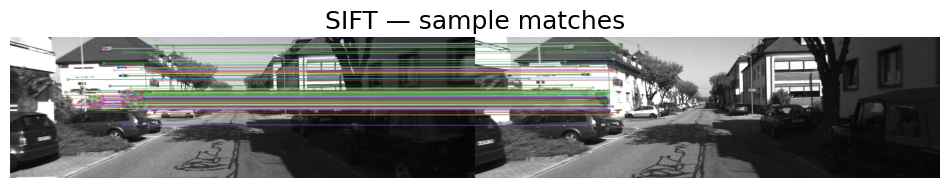

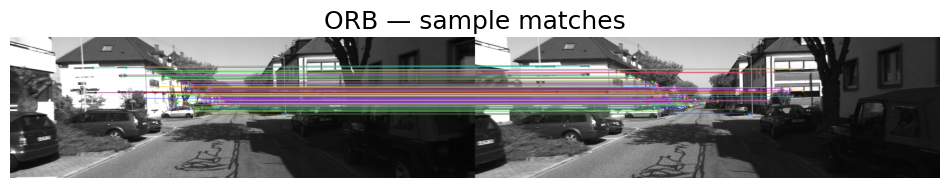

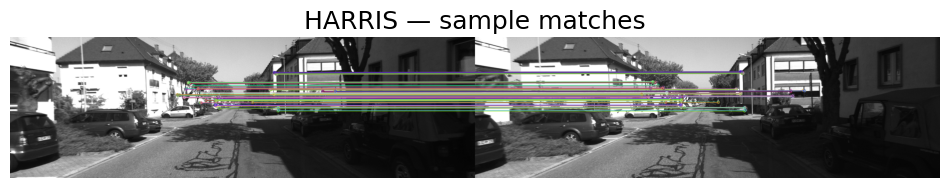

In [213]:
visuals = {}

for m in methods:
    det_res = all_results[m]["detection_results"]
    matches = all_results[m]["matches_between_frames"]

    visuals[m] = draw_matches_from_outputs(
        imgs, det_res, matches,
        frame_index=70, max_draw=150
    )
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(visuals[m], cv2.COLOR_BGR2RGB))
    plt.title(f"{m} — sample matches", fontsize=18)
    plt.axis('off')
    plt.show()


In [235]:
metrics_list = []
for method, res in all_results.items():
    m = res["metrics"].copy()
    m["method"] = method
    metrics_list.append(m)

df = pd.DataFrame(metrics_list)

df = df[[
    "method",
    "runtime_ms_total_detection",
    "runtime_ms_total_matching",
    "runtime_ms_total_pipeline",
    "runtime_ms_per_frame_avg",
    "avg_candidates_per_frame",
    f"num_landmarks_ge_{MIN_TRACK_LEN}",
]]

df.style.format({
    "runtime_ms_total_detection": "{:.1f}",
    "runtime_ms_total_matching": "{:.1f}",
    "runtime_ms_total_pipeline": "{:.1f}",
    "runtime_ms_per_frame_avg": "{:.1f}",
    "avg_candidates_per_frame": "{:.0f}",
})


In [239]:
def visualize_matches_overlay_for_method(method, frame_index, all_results, blend_img2=True, max_draw=800, thickness=1):
    """
    Draw red crosses at features on img(frame_index) and green lines/arrows
    to matched points from img(frame_index+1), using matches + keypoints from
    a specific detection method stored in all_results.
    """
    dets = all_results[method]["detection_results"]
    matches = all_results[method]["matches_between_frames"]

    img1 = imgs[frame_index]
    img2 = imgs[frame_index + 1]
    kp1 = dets[frame_index].key_points
    kp2 = dets[frame_index + 1].key_points
    mlist = matches[frame_index]

    base = img1.copy()
    if len(base.shape) == 2:
        base = cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)
    overlay = base.copy()

    if len(mlist) >= 8:
        pts1 = np.float32([kp1[m.queryIdx].pt for m in mlist])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in mlist])
        H, mask = cv2.findHomography(pts2, pts1, cv2.RANSAC, 3.0)
        inliers = mask.ravel().astype(bool) if mask is not None else np.zeros(len(mlist), bool)
    else:
        H, inliers = None, np.zeros(len(mlist), bool)

    if blend_img2 and H is not None:
        h, w = img1.shape[:2]
        img2b = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR) if len(img2.shape) == 2 else img2
        warped = cv2.warpPerspective(img2b, H, (w, h))
        overlay = cv2.addWeighted(overlay, 0.6, warped, 0.4, 0)

    for kp in kp1:
        p = tuple(map(int, kp.pt))
        cv2.drawMarker(overlay, p, (0,0,255), markerType=cv2.MARKER_TILTED_CROSS,
                       markerSize=8, thickness=1)

    drawn = 0
    for m, ok in zip(mlist, inliers if H is not None else [True]*len(mlist)):
        if drawn >= max_draw: break
        if not ok: continue
        p1 = tuple(map(int, kp1[m.queryIdx].pt))
        p2 = kp2[m.trainIdx].pt
        if H is not None:
            p2p = cv2.perspectiveTransform(np.array([[p2]], dtype=np.float32), H)[0,0]
            p2 = tuple(map(int, p2p))
        else:
            p2 = tuple(map(int, p2))
        cv2.arrowedLine(overlay, p1, p2, (0,255,0), thickness=thickness, tipLength=0.25)
        cv2.circle(overlay, p2, 2, (0,255,0), -1)
        drawn += 1

    return overlay


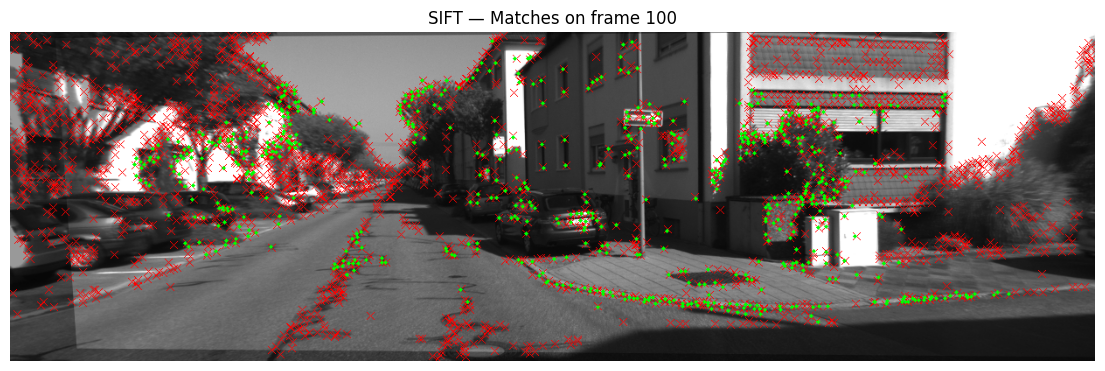

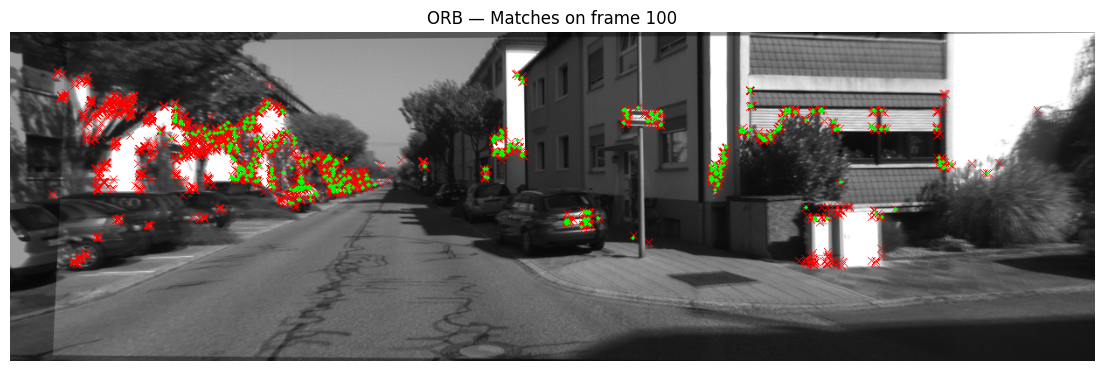

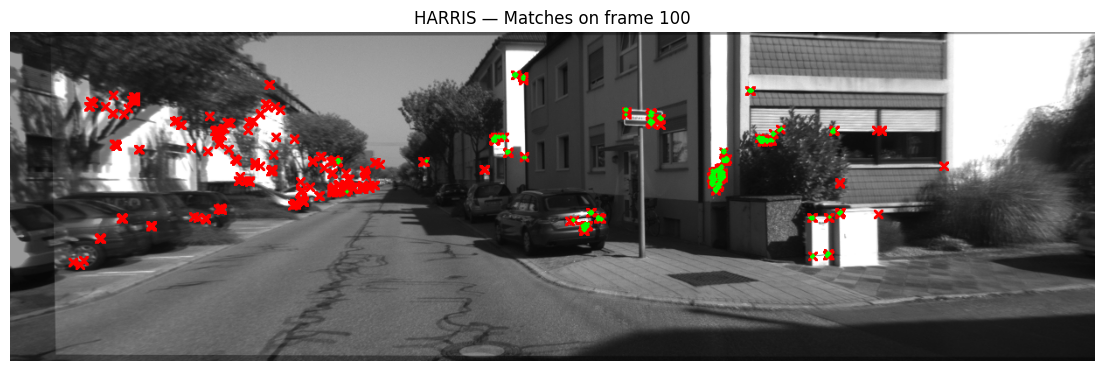

In [233]:
frame_to_show = 100

for method in ["SIFT", "ORB", "HARRIS"]:
    overlay = visualize_matches_overlay_for_method(
        method, frame_to_show, all_results,
        blend_img2=True, max_draw=1200, thickness=1
    )
    plt.figure(figsize=(14,5))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"{method} — Matches on frame {frame_to_show}")
    plt.axis("off")
    plt.show()


In [237]:
def test_orb_keypoint_size():
    try:
        img = cv2.imread('img2.png', 0)
        if img is None:
            raise FileNotFoundError
    except:
        print("no file found")
        return

    print(f"Image shape: {img.shape}")
    print(f"Image dtype: {img.dtype}")
    print(f"Pixel value range: {img.min()} - {img.max()}")
    
    center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
    
    patch_size = 40
    y1 = max(0, center_y - patch_size//2)
    y2 = min(img.shape[0], center_y + patch_size//2)
    x1 = max(0, center_x - patch_size//2)
    x2 = min(img.shape[1], center_x + patch_size//2)
    patch = img[y1:y2, x1:x2]
    
    print(f"\nLocal patch statistics around test point ({center_x}, {center_y}):")
    print(f"Patch std dev: {np.std(patch):.2f}")
    print(f"Patch mean: {np.mean(patch):.2f}")
    print(f"Patch size: {patch.shape}")
    
    sizes_to_test = [3, 9, 15, 31]
    descriptors = {}
    
    orb = cv2.ORB_create()
    
    for size in sizes_to_test:
        kp = cv2.KeyPoint(float(center_x), float(center_y), float(size))
        _, desc = orb.compute(img, [kp])
        
        if desc is not None:
            descriptors[size] = desc[0]
            print(f"\nSize {size:2d}: {desc[0][:10]} ... (std: {np.std(desc[0]):.2f})")
        else:
            print(f"\nSize {size:2d}: No descriptor computed!")
    
    print("\n--- Pairwise Hamming Distances ---")
    sizes = list(descriptors.keys())
    for i, size1 in enumerate(sizes):
        for j, size2 in enumerate(sizes):
            if i < j:  # Only upper triangle
                dist = cv2.norm(descriptors[size1], descriptors[size2], cv2.NORM_HAMMING)
                print(f"Size {size1:2d} vs Size {size2:2d}: {dist:3.0f}/256 bits different ({dist/256*100:.1f}%)")
    
    print("\n--- Testing Multiple Locations ---")
    test_points = [
        (50, 50),   # Upper left area
        (150, 50),  # Upper right area  
        (100, 150), # Lower center
        (center_x, center_y)  # Center
    ]
    
    for x, y in test_points:
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            kp_small = cv2.KeyPoint(float(x), float(y), 3.0)
            kp_large = cv2.KeyPoint(float(x), float(y), 31.0)
            
            _, desc_small = orb.compute(img, [kp_small])
            _, desc_large = orb.compute(img, [kp_large])
            
            if desc_small is not None and desc_large is not None:
                dist = cv2.norm(desc_small, desc_large, cv2.NORM_HAMMING)
                local_patch = img[max(0,y-10):min(img.shape[0],y+10), 
                                max(0,x-10):min(img.shape[1],x+10)]
                patch_std = np.std(local_patch)
                print(f"Point ({x:3d},{y:3d}): {dist:3.0f} bits diff, local texture std: {patch_std:.1f}")

test_orb_keypoint_size()

Image shape: (1795, 1202)
Image dtype: uint8
Pixel value range: 0 - 254

Local patch statistics around test point (601, 897):
Patch std dev: 9.12
Patch mean: 98.45
Patch size: (40, 40)

Size  3: [177  13  94 188  30 194  64 110 192 208] ... (std: 71.77)

Size  9: [177  13  94 188  30 194  64 110 192 208] ... (std: 71.77)

Size 15: [177  13  94 188  30 194  64 110 192 208] ... (std: 71.77)

Size 31: [177  13  94 188  30 194  64 110 192 208] ... (std: 71.77)

--- Pairwise Hamming Distances ---
Size  3 vs Size  9:   0/256 bits different (0.0%)
Size  3 vs Size 15:   0/256 bits different (0.0%)
Size  3 vs Size 31:   0/256 bits different (0.0%)
Size  9 vs Size 15:   0/256 bits different (0.0%)
Size  9 vs Size 31:   0/256 bits different (0.0%)
Size 15 vs Size 31:   0/256 bits different (0.0%)

--- Testing Multiple Locations ---
Point ( 50, 50):   0 bits diff, local texture std: 9.1
Point (150, 50):   0 bits diff, local texture std: 9.6
Point (100,150):   0 bits diff, local texture std: 9.8
Po

In [299]:
import time
import pandas as pd

def tune_detectors_with_landmarks(img_gray, img_seq):
    results = []

    for params in [{}, {"nfeatures": 500}, {"nfeatures": 2000}]:
        sift = cv2.SIFT_create(**params)
        kp, desc = sift.detectAndCompute(img_gray, None)

        t0 = time.time()
        _, _, _, tracks = run_pipeline(img_seq, method="SIFT")
        runtime_ms = (time.time() - t0) * 1000.0

        n_landmarks = count_stable_landmarks(tracks, MIN_TRACK_LEN)

        results.append({
            "method": "SIFT",
            "params": params,
            "num_kp": len(kp),
            "runtime_ms_total": runtime_ms,
            "landmarks": n_landmarks
        })

    for params in [{}, {"nfeatures": 1000}, {"nfeatures": 2000}]:
        orb = cv2.ORB_create(**params)
        kp, desc = orb.detectAndCompute(img_gray, None)

        t0 = time.time()
        _, _, _, tracks = run_pipeline(img_seq, method="ORB")
        runtime_ms = (time.time() - t0) * 1000.0

        n_landmarks = count_stable_landmarks(tracks, MIN_TRACK_LEN)

        results.append({
            "method": "ORB",
            "params": params,
            "num_kp": len(kp),
            "runtime_ms_total": runtime_ms,
            "landmarks": n_landmarks
        })

    harris_sets = [
        {"blockSize": 2, "ksize": 3, "k": 0.04, "thresh_rel": 0.01, "nfeatures_desc": 500},
        {"blockSize": 2, "ksize": 3, "k": 0.04, "thresh_rel": 0.005, "nfeatures_desc": 1000},
        {"blockSize": 2, "ksize": 3, "k": 0.04, "thresh_rel": 0.001, "nfeatures_desc": 10000}
    ]
    for params in harris_sets:
        res = detect_harris_with_orb_descriptors(img_gray, **params)

        t0 = time.time()
        _, _, _, tracks = run_pipeline(img_seq, method="HARRIS")
        runtime_ms = (time.time() - t0) * 1000.0

        n_landmarks = count_stable_landmarks(tracks, MIN_TRACK_LEN)

        results.append({
            "method": "HARRIS+ORB",
            "params": params,
            "num_kp": len(res.key_points),
            "runtime_ms_total": runtime_ms,
            "landmarks": n_landmarks
        })

    return pd.DataFrame(results)


In [301]:
df_tune = tune_detectors_with_landmarks(imgs[0], imgs)
df_tune

method                                             params  num_kp  \
0        SIFT                                                 {}    3206   
1        SIFT                                 {'nfeatures': 500}     500   
2        SIFT                                {'nfeatures': 2000}    2000   
3         ORB                                                 {}     500   
4         ORB                                {'nfeatures': 1000}    1000   
5         ORB                                {'nfeatures': 2000}    2000   
6  HARRIS+ORB  {'blockSize': 2, 'ksize': 3, 'k': 0.04, 'thres...     491   
7  HARRIS+ORB  {'blockSize': 2, 'ksize': 3, 'k': 0.04, 'thres...     965   
8  HARRIS+ORB  {'blockSize': 2, 'ksize': 3, 'k': 0.04, 'thres...    8810   

   runtime_ms_total  landmarks  
0      25535.672188      18118  
1      23116.834879      18118  
2      23958.901644      18118  
3       5052.372456      15204  
4       5882.629395      15204  
5       5059.609652      15204  
6       5662.712812       6505  
7       5696.639538       6505  
8       4989.267588       6505

In [255]:
def tune_detectors_with_landmarks_with_geo(img_gray, img_seq):
    results = []

    def filter_matches_with_geo(detection_results, matches_between_frames):
        filtered = []
        for frame_idx, matches in enumerate(matches_between_frames):
            kp1 = detection_results[frame_idx].key_points
            kp2 = detection_results[frame_idx + 1].key_points
            filtered.append(geometric_filter(kp1, kp2, matches, RANSAC_REPROJ_THR))
        return filtered

    for params in [{}, {"nfeatures": 500}, {"nfeatures": 2000}]:
        sift = cv2.SIFT_create(**params)
        kp, desc = sift.detectAndCompute(img_gray, None)

        t0 = time.time()
        _, detection_results, matches_between_frames, tracks = run_pipeline(img_seq, method="SIFT")
        runtime_ms = (time.time() - t0) * 1000.0

        matches_between_frames = filter_matches_with_geo(detection_results, matches_between_frames)
        n_landmarks = count_stable_landmarks(tracks, MIN_TRACK_LEN)

        results.append({
            "method": "SIFT",
            "params": params,
            "num_kp": len(kp),
            "runtime_ms_total": runtime_ms,
            "landmarks": n_landmarks
        })

    for params in [{"nfeatures": 500}, {"nfeatures": 1000}, {"nfeatures": 2000}]:
        orb = cv2.ORB_create(**params)
        kp, desc = orb.detectAndCompute(img_gray, None)

        t0 = time.time()
        _, detection_results, matches_between_frames, tracks = run_pipeline(img_seq, method="ORB")
        runtime_ms = (time.time() - t0) * 1000.0

        matches_between_frames = filter_matches_with_geo(detection_results, matches_between_frames)
        n_landmarks = count_stable_landmarks(tracks, MIN_TRACK_LEN)

        results.append({
            "method": "ORB",
            "params": params,
            "num_kp": len(kp),
            "runtime_ms_total": runtime_ms,
            "landmarks": n_landmarks
        })

    harris_sets = [
        {"blockSize": 2, "ksize": 3, "k": 0.04, "thresh_rel": 0.01, "nfeatures_desc": 500},
        {"blockSize": 2, "ksize": 3, "k": 0.04, "thresh_rel": 0.005, "nfeatures_desc": 1000},
        {"blockSize": 2, "ksize": 3, "k": 0.04, "thresh_rel": 0.001, "nfeatures_desc": 2000},
        {"blockSize": 2, "ksize": 3, "k": 0.04, "thresh_rel": 0.001, "nfeatures_desc": 2000}
    ]
    for params in harris_sets:
        res = detect_harris_with_orb_descriptors(img_gray, **params)

        t0 = time.time()
        _, detection_results, matches_between_frames, tracks = run_pipeline(img_seq, method="HARRIS")
        runtime_ms = (time.time() - t0) * 1000.0

        matches_between_frames = filter_matches_with_geo(detection_results, matches_between_frames)
        n_landmarks = count_stable_landmarks(tracks, MIN_TRACK_LEN)

        results.append({
            "method": "HARRIS+ORB",
            "params": params,
            "num_kp": len(res.key_points),
            "runtime_ms_total": runtime_ms,
            "landmarks": n_landmarks
        })

    return pd.DataFrame(results)



In [257]:
df_tune_new = tune_detectors_with_landmarks_with_geo(imgs[0], imgs)
df_tune_new

method                                             params  num_kp  \
0        SIFT                                                 {}    3206   
1        SIFT                                 {'nfeatures': 500}     500   
2        SIFT                                {'nfeatures': 2000}    2000   
3         ORB                                 {'nfeatures': 500}     500   
4         ORB                                {'nfeatures': 1000}    1000   
5         ORB                                {'nfeatures': 2000}    2000   
6  HARRIS+ORB  {'blockSize': 2, 'ksize': 3, 'k': 0.04, 'thres...     491   
7  HARRIS+ORB  {'blockSize': 2, 'ksize': 3, 'k': 0.04, 'thres...     965   
8  HARRIS+ORB  {'blockSize': 2, 'ksize': 3, 'k': 0.04, 'thres...    1934   

   runtime_ms_total  landmarks  
0      30922.714710      10410  
1      25440.536022      10410  
2      25529.207945      10410  
3       5917.769432      10362  
4       5205.804110      10362  
5       5928.489208      10362  
6       5084.180832       5618  
7       6176.226377       5618  
8       5182.563782       5618